In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional
import torch.utils.data

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

plt.style.use('ggplot')

%matplotlib inline

# Set the seed
seed_value = 1

# Set random seed for random
random.seed(seed_value)
# Set random seed for NumPy
np.random.seed(seed_value)
# Set random seed for PyTorch
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Define
- the number of observation: n_obs = 1000 (same environment as the DCM paper)
- the number of samples from DCM and BDCM: n_sample_DCM = 500 (same environment as the DCM paper)

In [ ]:
# deifne the number of samples in observational data X
# n_obs = 5000 # same number of samples that
n_obs = 1000 # shorter version

# Define the number of samples we want to approximate the target
# n_sample_DCM = 1000 # same environment as DCM paper
n_sample_DCM = 500 # shorter version

## DCM Training

Define
- time: $T = 100$
- noise schedule: $\beta_t$ and $\alpha_t$ for all $i = 1, \cdots, T$

In [ ]:
# Define T, mu, sigma
T = 100
mu = 0
sigma = 1

# Define the noise schedule
# alpha_t = \prod_{i \le t} (1 - \beta_i)

# Define beta_t
beta_t = (0.1 - 0.0001) * (np.linspace(1, T, T) - 1) / (T - 1) + 0.0001

# Define alpha_t
alpha_t = np.zeros(T)
for i in range(len(beta_t)):
    if i == 0:
        alpha_t[i] = (1 - beta_t[i])
    else:
        alpha_t[i] = (1 - beta_t[i]) * alpha_t[i - 1]


Define
- the structural equation: $X_i = f(PA(X_i)) + U_i$
  - $X_1 = U_1$
  - $X_2 = X_1^2 + U_2$
  - $X_3 = X_2 + U_3$
  - $X_4 = X_1 X_3 + X_1 + X_3^2 + U_4$

Sample
- exogeneous nodes: $U_1, U_2, U_3, U_4 \sim \mathcal{N}(0, 1)$
- endogenous nodes: $X_1, X_2, X_3, X_4$
- intervened nodes: $X_4|do(X_1 = x_1)$
- time: $t \sim \mathcal{N}(0, 1)$
- noise: $\epsilon \sim \mathcal{N}(0, 1)$


In [ ]:
# Sample exogenous nodes U_i ~ N(mu, sigma)
u1 = np.random.normal(mu, sigma, n_obs)
u2 = np.random.normal(mu, sigma, n_obs)
u3 = np.random.normal(mu, sigma, n_obs)
u4 = np.random.normal(mu, sigma, n_obs)

# Define the structual equation
# X_i = f_i(X_{pa_i}) + U_i
def create_x1(u1):
    return u1

def create_x2(x1, u2):
    return x1 ** 2 + u2

def create_x3(x2, u3):
    return x2 + u3

def create_x4(x1, x3, u4):
    return x1 * x3 + x1 + x3 ** 2 + u4

# Define the function to normalize
def normalize(x):
    return (x - np.mean(x)) / np.std(x)

# Sample endogenous nodes before SCM
x1 = create_x1(u1)
x1 = normalize(x1)
x2 = create_x2(x1, u2)
x2 = normalize(x2)
x3 = create_x3(x2, u3)
x3 = normalize(x3)
x4 = create_x4(x1, x3, u4)
x4 = normalize(x4)

# Sample intervened nodes
def true_sample_x4_do_x1(x1):
  x2_do = create_x2(x1, u2)
  x2_do =  normalize(x2_do)
  x3_do = create_x3(x2_do, u3)
  x3_do = normalize(x3_do)
  x4_do = create_x4(x1, x3_do, u4)
  x4_do = normalize(x4_do)
  return x4_do

# Generate t ~ Unif([T])
t_x1 = np.array([random.randint(1, T) for x in range(n_obs)])
t_x2 = np.array([random.randint(1, T) for x in range(n_obs)])
t_x3 = np.array([random.randint(1, T) for x in range(n_obs)])
t_x4 = np.array([random.randint(1, T) for x in range(n_obs)])

# Generate \epsilon ~ N(mu, sigma)
epsilon_x1 = np.random.normal(mu, sigma, n_obs)
epsilon_x2 = np.random.normal(mu, sigma, n_obs)
epsilon_x3 = np.random.normal(mu, sigma, n_obs)
epsilon_x4 = np.random.normal(mu, sigma, n_obs)

Create the inputs for the neural network $\epsilon_{\theta}^3$ of node $X_3$

In [ ]:
# Get the alpha_t for training
alpha_t_train_x1 = np.zeros(n_obs)
alpha_t_train_x2 = np.zeros(n_obs)
alpha_t_train_x3 = np.zeros(n_obs)
alpha_t_train_x4 = np.zeros(n_obs)
for i in range(n_obs):
    alpha_t_train_x1[i] = alpha_t[t_x1[i] - 1]
    alpha_t_train_x2[i] = alpha_t[t_x2[i] - 1]
    alpha_t_train_x3[i] = alpha_t[t_x3[i] - 1]
    alpha_t_train_x4[i] = alpha_t[t_x4[i] - 1]

# Define the function to create the first input to the neural network
def create_input_1(alpha_t, x, epsilon):
    return np.sqrt(alpha_t) * x + np.sqrt(1 - alpha_t) * epsilon


# Create the input for the neural network

# First input by using the predefined function
input_1_x2 = create_input_1(alpha_t_train_x2, x2, epsilon_x2)
# Concatenate the inputs
input_x2 = np.stack([input_1_x2, x1, t_x2], axis=1)

# First input by using the predefined function
input_1_x4 = create_input_1(alpha_t_train_x4, x4, epsilon_x4)
# Concatenate the inputs
input_x4 = np.stack([input_1_x4, x1, t_x4], axis=1)

# First input by using the predefined function
input_1_x4_BDCM = create_input_1(alpha_t_train_x4, x4, epsilon_x4)
# Concatenate the inputs
input_x4_BDCM = np.stack([input_1_x4, x1, x2, t_x4], axis=1)



Define
- epoch: num_epochs = 500
- batch size: batch_size = 64
- learning rate: learning_rate $\eta$ = 0.0001
- number of samples to get by DCM: n_sample_DCM = 1000

In [ ]:
# define the epoch, batch size, and learning rate
num_epochs = 500
batch_size = 64
learning_rate = 0.0001


In [ ]:
# Define the data class to do mini batch learning
class MakeDataset(torch.utils.data.Dataset):

    def __init__(self, x, y=None):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        x = torch.from_numpy(self.x[i]).float()
        if self.y is not None:
            y = torch.from_numpy(self.y[i]).float()

        if self.y is not None:
            return x, y
        else:
            return x

Neural Network: 3 hidden layers
- 1st layer: 128 nodes
- 2nd layer: 256 nodes
- 3rd layer: 256 nodes

In [ ]:
# Define the nueral network to be used for X_2 in DCM
class Net_x2(torch.nn.Module):

  def __init__(self):
    super(Net_x2, self).__init__()
    self.fc1 = torch.nn.Linear(3, 128)
    self.fc2 = torch.nn.Linear(128, 256)
    self.fc3 = torch.nn.Linear(256, 256)
    self.fc4 = torch.nn.Linear(256, 1)

  def forward(self, x):
    x = torch.nn.functional.silu(self.fc1(x))
    x = torch.nn.functional.silu(self.fc2(x))
    x = torch.nn.functional.silu(self.fc3(x))
    x = self.fc4(x)
    return x


# Define the nueral network to be used for X_4 in DCM
class Net_x4(torch.nn.Module):

  def __init__(self):
    super(Net_x4, self).__init__()
    self.fc1 = torch.nn.Linear(3, 128)
    self.fc2 = torch.nn.Linear(128, 256)
    self.fc3 = torch.nn.Linear(256, 256)
    self.fc4 = torch.nn.Linear(256, 1)

  def forward(self, x):
    x = torch.nn.functional.silu(self.fc1(x))
    x = torch.nn.functional.silu(self.fc2(x))
    x = torch.nn.functional.silu(self.fc3(x))
    x = self.fc4(x)
    return x

# Define the nueral network to be used for X_4 in BDCM
class Net_x4_BDCM(torch.nn.Module):

  def __init__(self):
    super(Net_x4_BDCM, self).__init__()
    self.fc1 = torch.nn.Linear(4, 128)
    self.fc2 = torch.nn.Linear(128, 256)
    self.fc3 = torch.nn.Linear(256, 256)
    self.fc4 = torch.nn.Linear(256, 1)

  def forward(self, x):
    x = torch.nn.functional.silu(self.fc1(x))
    x = torch.nn.functional.silu(self.fc2(x))
    x = torch.nn.functional.silu(self.fc3(x))
    x = self.fc4(x)
    return x

Train the Neural Network

In [ ]:
# Prepare dataset for X_2
dataset_x2 = MakeDataset(input_x2, epsilon_x2.reshape(-1, 1))
dataloader_x2 = torch.utils.data.DataLoader(dataset_x2, batch_size=batch_size, shuffle=True)

# Prepare model and training parameters
# Instantiate the Neural Network
net_x2 = Net_x2()
# Chnage the Neural Network to the training mode
net_x2.train()
# Define the optimizer
optimizer = torch.optim.Adam(net_x2.parameters(), lr=learning_rate)
# Define the criterion
criterion = torch.nn.MSELoss()

# Training
epoch_loss_x2 = []
for epoch in range(num_epochs):

    # use 'dataloader' to start batch learning
    running_loss = 0   # loss in this epoch
    for inputs, labels in dataloader_x2:
        outputs = net_x2(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # add loss of this batch to loss of epoch
        running_loss += loss.data.numpy().tolist()

    epoch_loss_x2.append(running_loss)

In [ ]:
# Prepare dataset for X_4 in DCM
dataset_x4 = MakeDataset(input_x4, epsilon_x4.reshape(-1, 1))
dataloader_x4 = torch.utils.data.DataLoader(dataset_x4, batch_size=batch_size, shuffle=True)

# Prepare model and training parameters
# Instantiate the Neural Network
net_x4 = Net_x4()
# Chnage the Neural Network to the training mode
net_x4.train()
# Define the optimizer
optimizer = torch.optim.Adam(net_x4.parameters(), lr=learning_rate)
# Define the criterion
criterion = torch.nn.MSELoss()

# Training
epoch_loss_x4 = []
for epoch in range(num_epochs):

    # use 'dataloader' to start batch learning
    running_loss = 0   # loss in this epoch
    for inputs, labels in dataloader_x4:
        outputs = net_x4(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # add loss of this batch to loss of epoch
        running_loss += loss.data.numpy().tolist()

    epoch_loss_x4.append(running_loss)

In [ ]:
# Prepare dataset for X_4 for BDCM
dataset_x4_BDCM = MakeDataset(input_x4_BDCM, epsilon_x4.reshape(-1, 1))
dataloader_x4_BDCM = torch.utils.data.DataLoader(dataset_x4_BDCM, batch_size=batch_size, shuffle=True)

# Prepare model and training parameters
# Instantiate the Neural Network
net_x4_BDCM = Net_x4_BDCM()
# Chnage the Neural Network to the training mode
net_x4_BDCM.train()
# Define the optimizer
optimizer = torch.optim.Adam(net_x4_BDCM.parameters(), lr=learning_rate)
# Define the criterion
criterion = torch.nn.MSELoss()

# Training
epoch_loss_x4_BDCM = []
for epoch in range(num_epochs):

    # use 'dataloader' to start batch learning
    running_loss = 0   # loss in this epoch
    for inputs, labels in dataloader_x4_BDCM:
        outputs = net_x4_BDCM(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # add loss of this batch to loss of epoch
        running_loss += loss.data.numpy().tolist()

    epoch_loss_x4_BDCM.append(running_loss)

Plot the loss of the training over the epoch

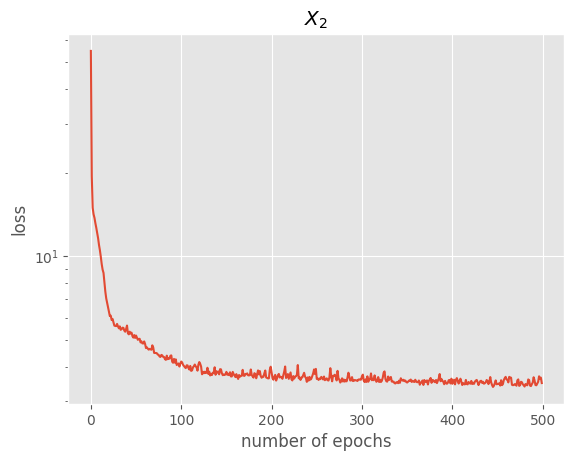

In [ ]:
# Plot the loss over the epoch
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss_x2))), epoch_loss_x2)
ax.set_xlabel('number of epochs')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.set_title('$X_2$')
fig.show()

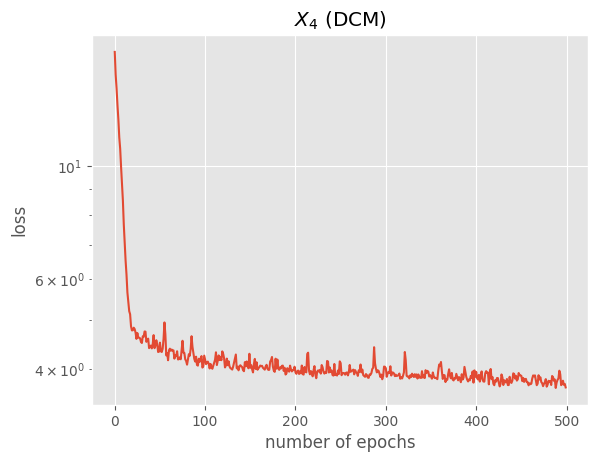

In [ ]:
# Plot the loss over the epoch
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss_x4))), epoch_loss_x4)
ax.set_xlabel('number of epochs')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.set_title('$X_4$ (DCM)')
fig.show()

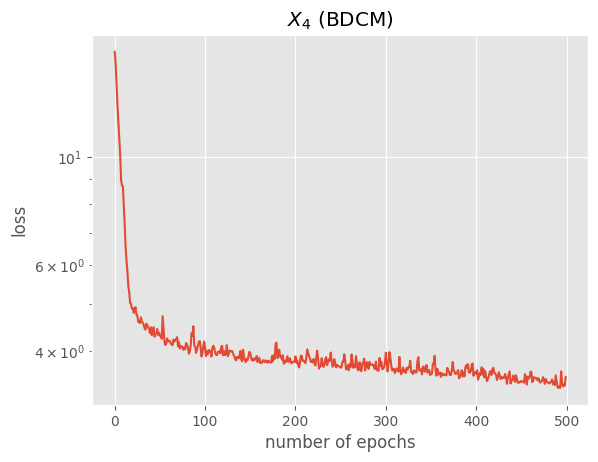

In [ ]:
# Plot the loss over the epoch
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss_x4_BDCM))), epoch_loss_x4_BDCM)
ax.set_xlabel('number of epochs')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.set_title('$X_4$ (BDCM)')
fig.show()

In [ ]:
# Define the decoder for X_2
# Dec_i(Z_i, X_{pa_i})
# Input: exogenous node and parent nodes
# Output: the last node in the reverse diffusion process
def DEC_2(z2, x2_parents):
    # Define the vector that preserves the variables obtained via the reverse diffusion process
    x2_hat = np.zeros(T + 1)
    # Initialize the start node of the reverse diffusion process
    x2_hat[T] = z2
    # Save the variables in the reverse diffusion process
    for i in range(1, T + 1):
        t = T + 1 - i

        # Change the network mode to evaluation
        net_x2.eval()
        # Define the inputs
        input_x2 = np.stack([np.array([x2_hat[t]]), np.array([x2_parents[0]]), np.array([t])], axis=1)
        # convert the input to tensor
        input_x2_tensor = torch.from_numpy(input_x2).float()
        # Make prediction
        with torch.no_grad():
            output_x2_tensor = net_x2(input_x2_tensor)
        # Convert the output to numpy data
        output_x2 = output_x2_tensor.data.numpy()
        # Calculate the next variable in the reverse diffusion process by the formula
        x2_hat[t - 1] = np.sqrt(alpha_t[t - 2] / alpha_t[t - 1]) * x2_hat[t] - output_x2[0][0] * (np.sqrt(alpha_t[t - 2] * (1 - alpha_t[t - 1]) / alpha_t[t - 1]) - np.sqrt(1 - alpha_t[t - 2]))
    # Return the last variable in the reverse diffusion process
    return x2_hat[0]

In [ ]:
# Define the decoder for X_4 in DCM
# Dec_i(Z_i, X_{pa_i})
# Input: exogenous node and parent nodes
# Output: the last node in the reverse diffusion process
def DEC_4(z4, x4_parents):
    # Define the vector that preserves the variables obtained via the reverse diffusion process
    x4_hat = np.zeros(T + 1)
    # Initialize the start node of the reverse diffusion process
    x4_hat[T] = z4
    # Save the variables in the reverse diffusion process
    for i in range(1, T + 1):
        t = T + 1 - i

        # Change the network mode to evaluation
        net_x4.eval()
        # Define the inputs
        input_x4 = np.stack([np.array([x4_hat[t]]), np.array([x4_parents[0]]), np.array([t])], axis=1)
        # convert the input to tensor
        input_x4_tensor = torch.from_numpy(input_x4).float()
        # Make prediction
        with torch.no_grad():
            output_x4_tensor = net_x4(input_x4_tensor)
        # Convert the output to numpy data
        output_x4 = output_x4_tensor.data.numpy()
        # Calculate the next variable in the reverse diffusion process by the formula
        x4_hat[t - 1] = np.sqrt(alpha_t[t - 2] / alpha_t[t - 1]) * x4_hat[t] - output_x4[0][0] * (np.sqrt(alpha_t[t - 2] * (1 - alpha_t[t - 1]) / alpha_t[t - 1]) - np.sqrt(1 - alpha_t[t - 2]))
    # Return the last variable in the reverse diffusion process
    return x4_hat[0]

In [ ]:
# Define the decoder for X_4 in BDCM
# Dec_i(Z_i, X_{pa_i})
# Input: exogenous node and parent nodes
# Output: the last node in the reverse diffusion process
def DEC_4_BDCM(z4_BDCM, x4_BDCM_parents):
    # Define the vector that preserves the variables obtained via the reverse diffusion process
    x4_BDCM_hat = np.zeros(T + 1)
    # Initialize the start node of the reverse diffusion process
    x4_BDCM_hat[T] = z4_BDCM
    # Save the variables in the reverse diffusion process
    for i in range(1, T + 1):
        t = T + 1 - i

        # Change the network mode to evaluation
        net_x4_BDCM.eval()
        # Define the inputs
        input_x4_BDCM = np.stack([np.array([x4_BDCM_hat[t]]), np.array([x4_BDCM_parents[0]]), np.array([x4_BDCM_parents[1]]), np.array([t])], axis=1)
        # convert the input to tensor
        input_x4_BDCM_tensor = torch.from_numpy(input_x4_BDCM).float()
        # Make prediction
        with torch.no_grad():
            output_x4_BDCM_tensor = net_x4_BDCM(input_x4_BDCM_tensor)
        # Convert the output to numpy data
        output_x4_BDCM = output_x4_BDCM_tensor.data.numpy()
        # Calculate the next variable in the reverse diffusion process by the formula
        x4_BDCM_hat[t - 1] = np.sqrt(alpha_t[t - 2] / alpha_t[t - 1]) * x4_BDCM_hat[t] - output_x4_BDCM[0][0] * (np.sqrt(alpha_t[t - 2] * (1 - alpha_t[t - 1]) / alpha_t[t - 1]) - np.sqrt(1 - alpha_t[t - 2]))
    # Return the last variable in the reverse diffusion process
    return x4_BDCM_hat[0]

In [ ]:
# Define the function to sample X_4 n times when we intervene to X_1 in DCM
# Input: the number of samples we want to obtain and the value of the intervention
# Output: the vector of the samples from the target distribution
def sample_X4(n_sample_DCM, x1_intervention):
    # Initialize the sample list by just zero vector
    x4_DDIM_list = np.zeros(n_sample_DCM)

    # Iteratively sample from the target distribution
    for i in range(n_sample_DCM):
        # Sample the optional noise Z_i
        z2 = np.random.normal(0, 1)
        z4 = np.random.normal(0, 1)
        # Set X_1 to the intervened value
        x1_sampled = x1_intervention
        # Concatenate the parents and nodes which satisfy the backdoor criterion
        x2_parents = np.array([x1_sampled])
        # Sample X_2 by using the decoder function
        x2_sampled = DEC_2(z2, x2_parents)
        # Concatenate the parents and nodes which satisfy the backdoor criterion
        x4_parents = np.array([x1_sampled])
        # Sample X_2 by using the decoder function
        x4_sampled = DEC_4(z4, x4_parents)
        # Add the sampled value to the list
        x4_DDIM_list[i] = x4_sampled

    return x4_DDIM_list

In [ ]:
# Define the function to sample X_4 n times when we intervene to X_1 in BDCM
# Input: the number of samples we want to obtain and the value of the intervention
# Output: the vector of the samples from the target distribution
def sample_X4_BDCM(n_sample_DCM, x1_intervention):
    # Initialize the sample list by just zero vector
    x4_BDCM_DDIM_list = np.zeros(n_sample_DCM)

    # Iteratively sample from the target distribution
    for i in range(n_sample_DCM):
        # Sample the optional noise Z_i
        z2 = np.random.normal(0, 1)
        z4 = np.random.normal(0, 1)
        # Set X_1 to the intervened value
        x1_sampled = x1_intervention
        # Concatenate the parents and nodes which satisfy the backdoor criterion
        x2_parents = np.array([x1_sampled])
        # Sample X_2 by using the decoder function
        x2_sampled = DEC_2(z2, x2_parents)
        # Concatenate the parents and nodes which satisfy the backdoor criterion
        x4_parents = np.array([x1_sampled, x2_sampled])
        # Sample X_2 by using the decoder function
        x4_BDCM_sampled = DEC_4_BDCM(z4, x4_parents)
        # Add the sampled value to the list
        x4_BDCM_DDIM_list[i] = x4_BDCM_sampled

    return x4_BDCM_DDIM_list

In [ ]:
# define the function to show the histogram of samples by DDIM and true target
def show_hist(x_sample, x_target, title_string):
  figure, axis = plt.subplots(1, 2, figsize=(14, 5))

  # unnormalized
  axis[0].hist(x_sample, 100, density = True, label = "sample")
  axis[0].hist(x_target, 100, density = True, alpha = 0.5, label = "target dist")
  axis[0].set_title("${}$ (before normalization)".format(title_string))
  axis[0].legend()

  # normalized
  axis[1].hist(normalize(x_sample), 100, density = True, label = "sample")
  axis[1].hist(normalize(x_target), 100, density = True, alpha = 0.5, label = "target dist")
  axis[1].set_title("${}$ (after normalization)".format(title_string))
  axis[1].legend()

  # Combine all the operations and display
  plt.show()

In [ ]:
# Define MMD function
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)

    return torch.mean(XX + YY - 2. * XY)

In [ ]:
def sample_and_plot_x4_do_x1(x1):
  # sample from the target when we intervene by do(X1 = x1)
  x4_do_DDIM = sample_X4(n_sample_DCM, x1)
  # plot the histograms of samples and target
  show_hist(x4_do_DDIM, true_sample_x4_do_x1(x1), "X_4|do(X_1 = {:.3}) DCM".format(x1))
  return x4_do_DDIM

def sample_and_plot_x4_do_x1_BDCM(x1):
  # sample from the target when we intervene by do(X1 = x1)
  x4_do_DDIM = sample_X4_BDCM(n_sample_DCM, x1)
  # plot the histograms of samples and target
  show_hist(x4_do_DDIM, true_sample_x4_do_x1(x1), "X_4|do(X_1 = {:.3}) BDCM".format(x1))
  return x4_do_DDIM

In [ ]:
# Create the array that save the intervened value, samples from DCM, samples from BDCM
# Input: array of intervened values
# Output: DCM and BDCM samples
def plot_and_save_array(array_interventions):
  # Get the number of interventions
  num_intervention = np.size(array_interventions)

  # Initialize the array of samples for DCM and BDCM
  array_DCM_samples = np.array([])
  array_BDCM_samples = np.array([])

  # for each intervention
  for i in range(num_intervention):
    if np.any(array_DCM_samples) == False:
      # Plot the empirical distribution of DCM and true target
      array_DCM_samples = np.append(array_DCM_samples, np.array([sample_and_plot_x4_do_x1(array_interventions[i])]))
      # Plot the empirical distribution of BDCM and true target
      array_BDCM_samples = np.append(array_BDCM_samples, np.array([sample_and_plot_x4_do_x1_BDCM(array_interventions[i])]))
    else:
      # Plot the empirical distribution of DCM and true target
      array_DCM_samples = np.vstack((array_DCM_samples, np.array([sample_and_plot_x4_do_x1(array_interventions[i])])))
      # Plot the empirical distribution of BDCM and true target
      array_BDCM_samples = np.vstack((array_BDCM_samples, np.array([sample_and_plot_x4_do_x1_BDCM(array_interventions[i])])))

  return array_DCM_samples, array_BDCM_samples


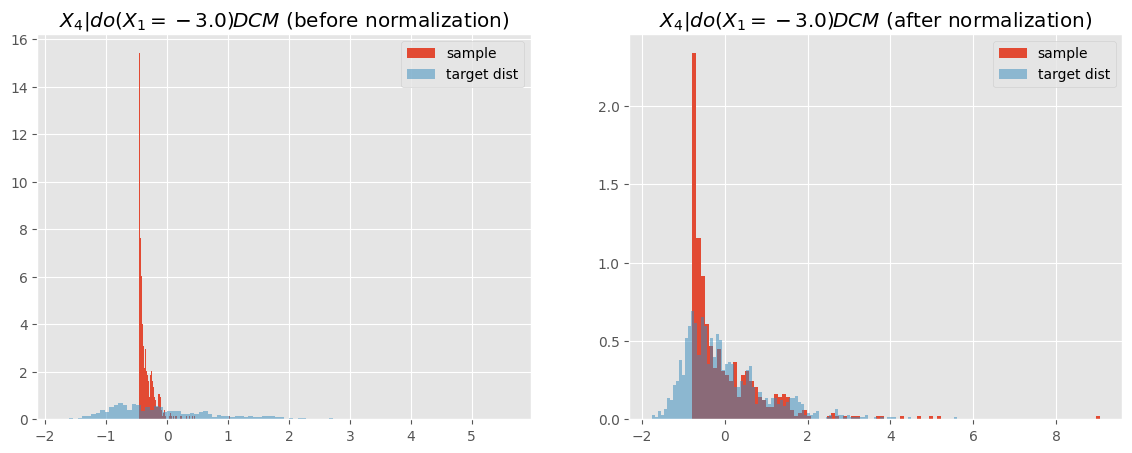

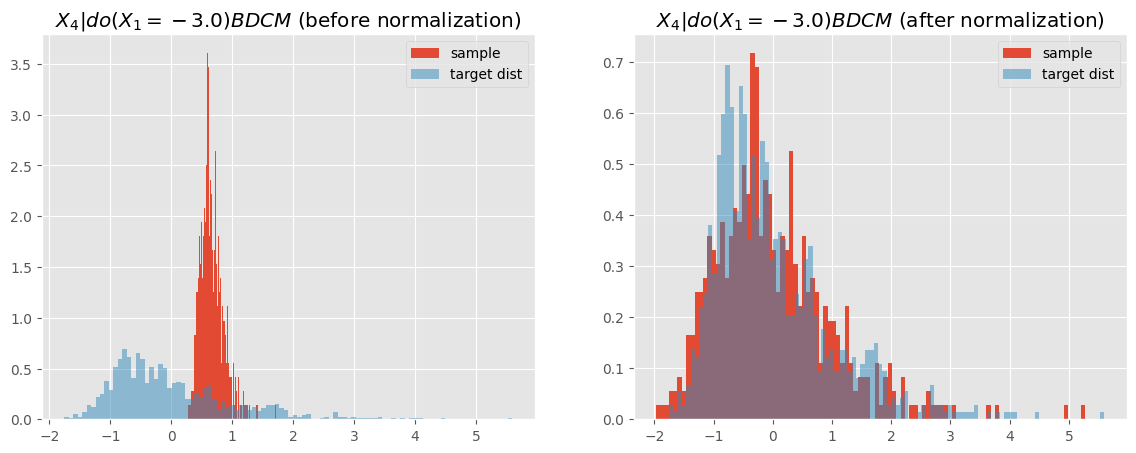

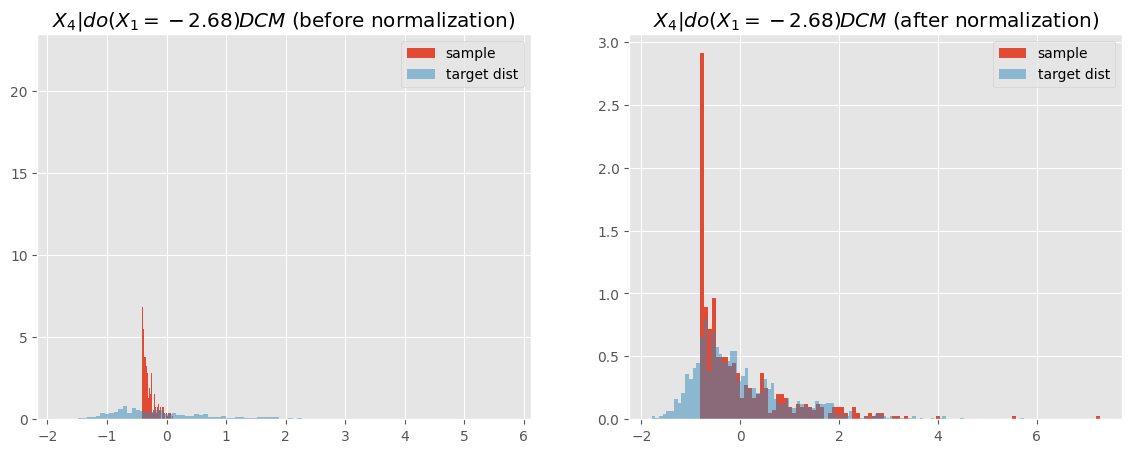

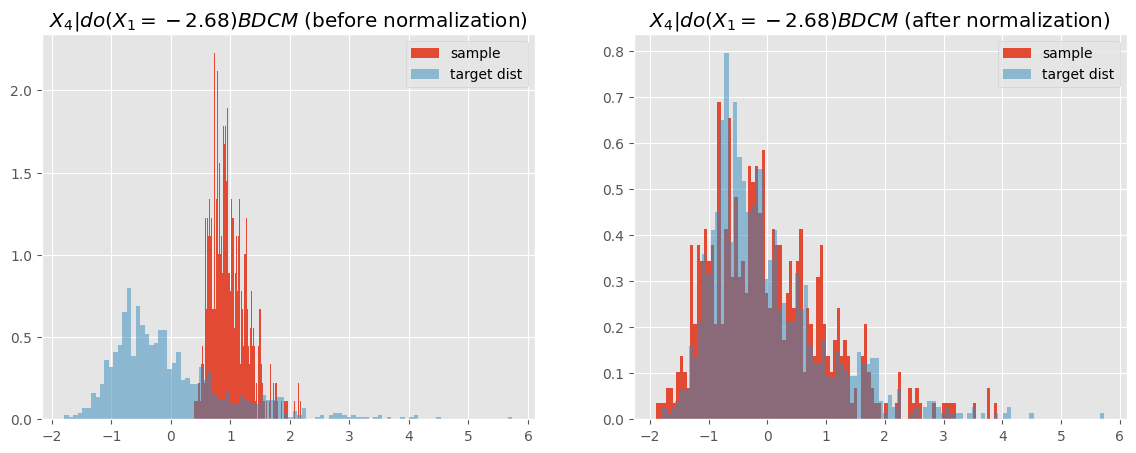

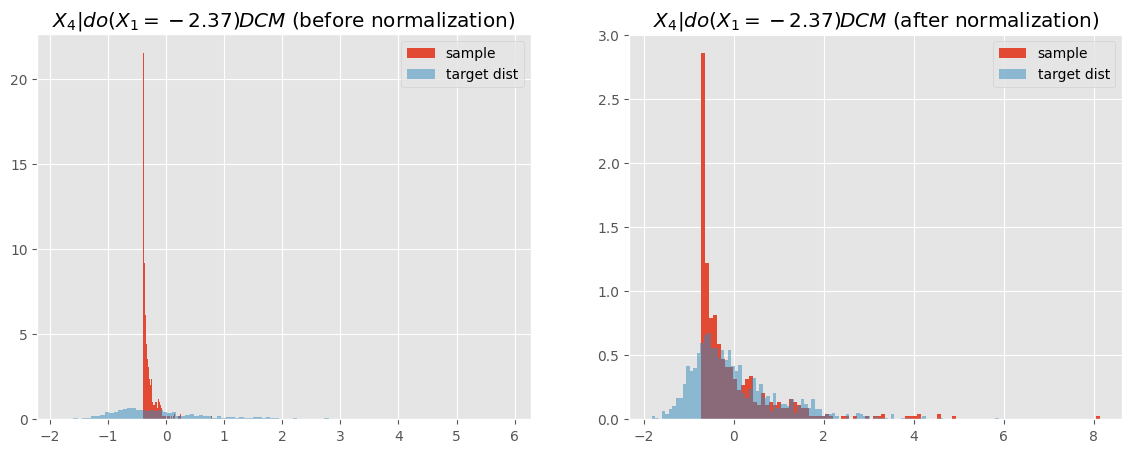

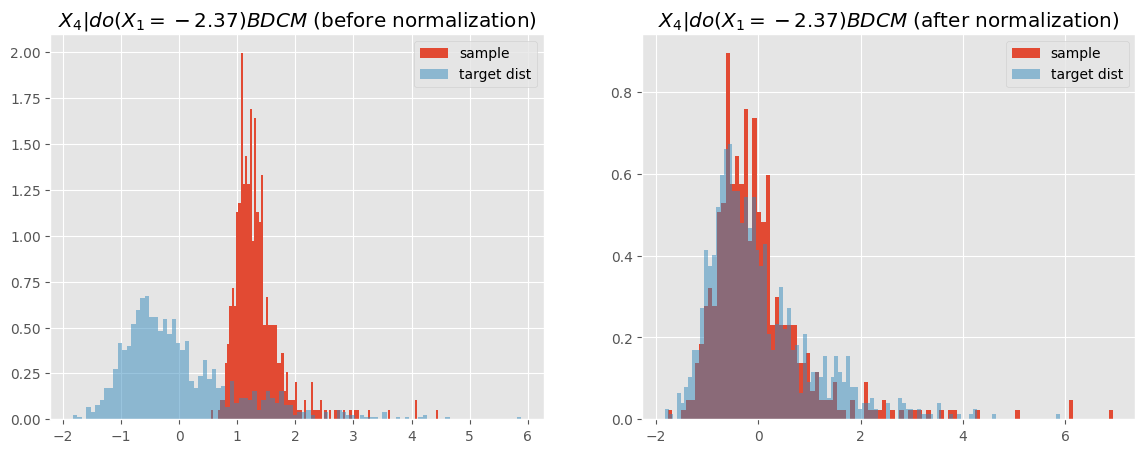

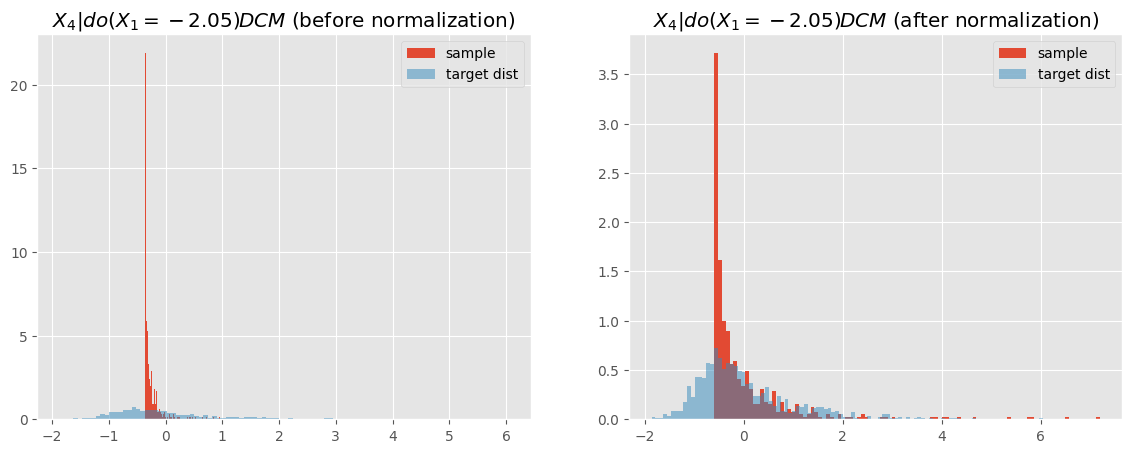

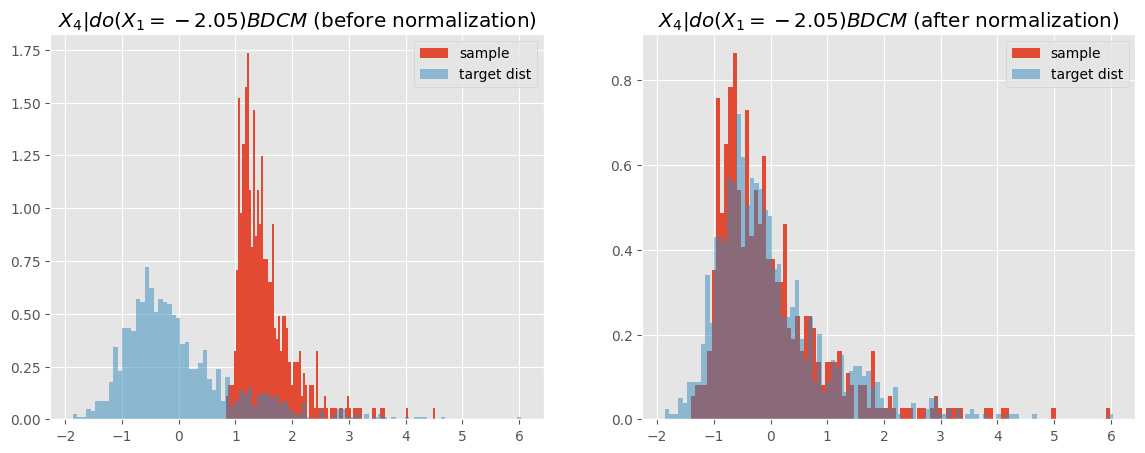

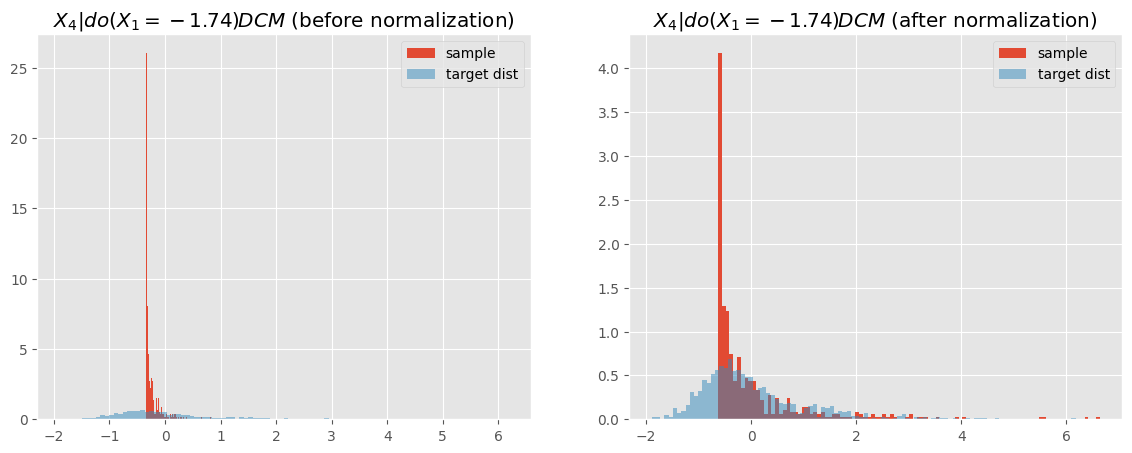

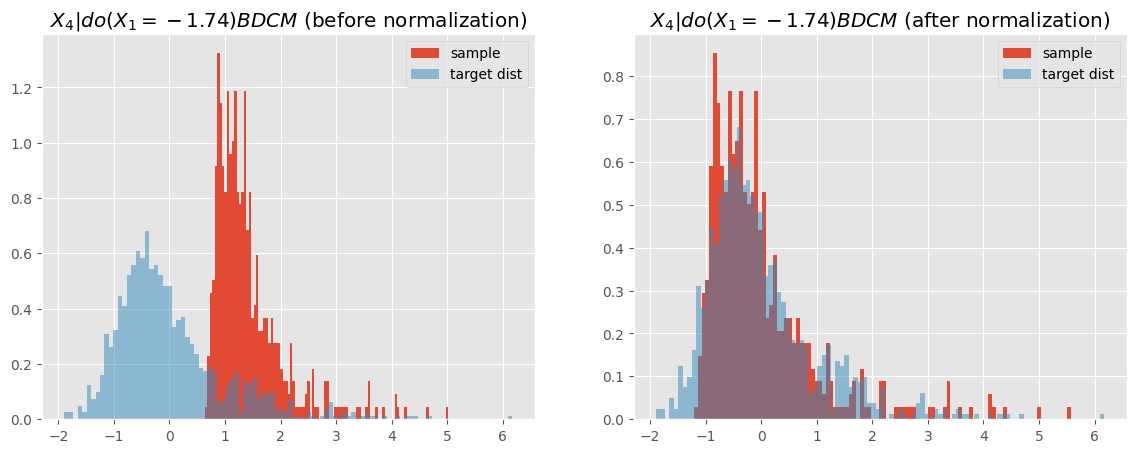

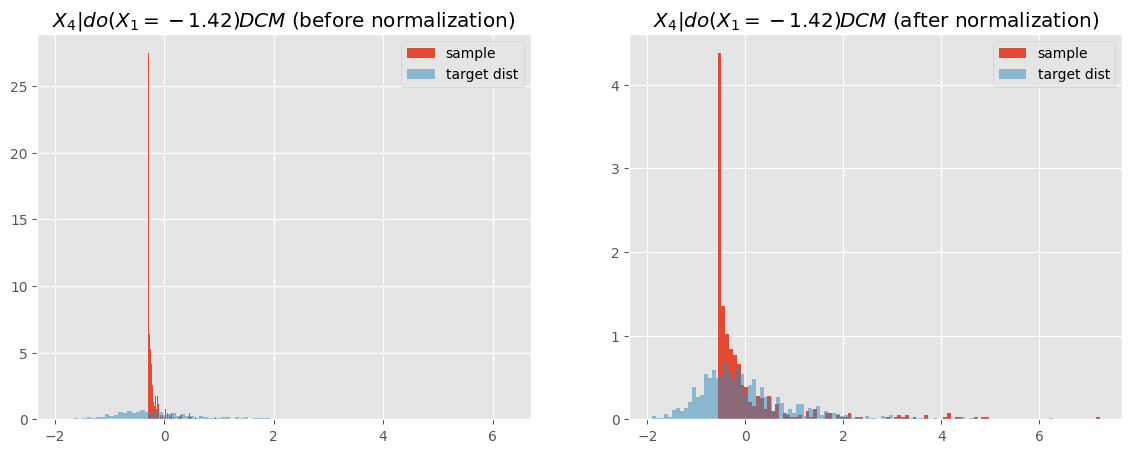

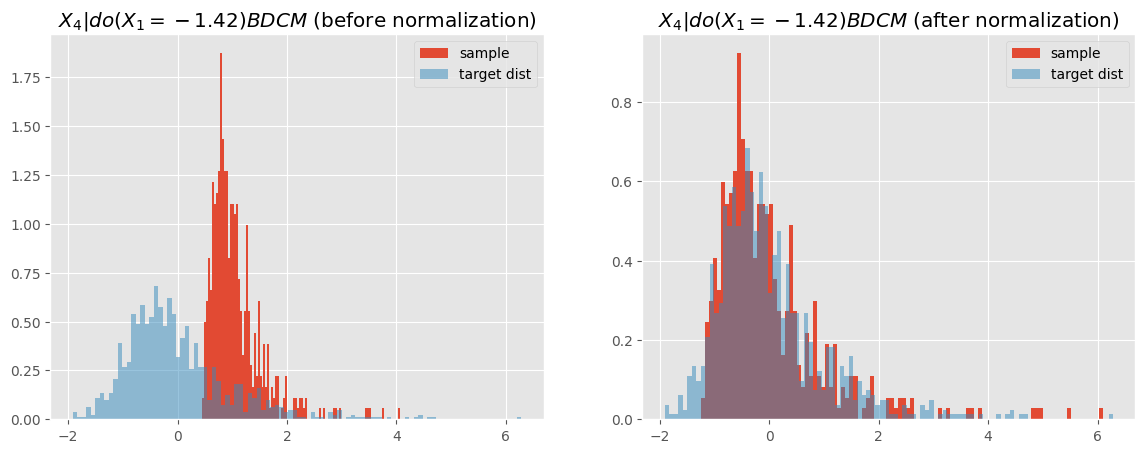

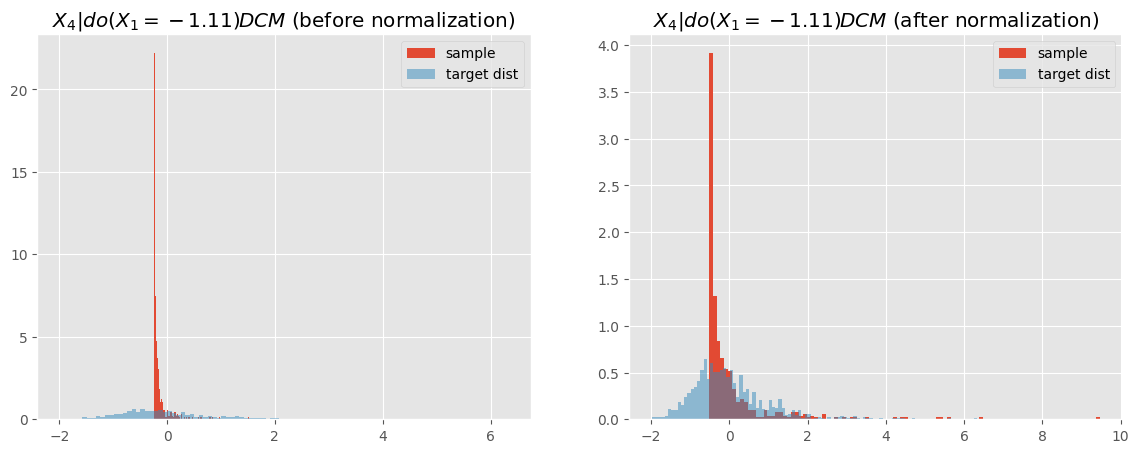

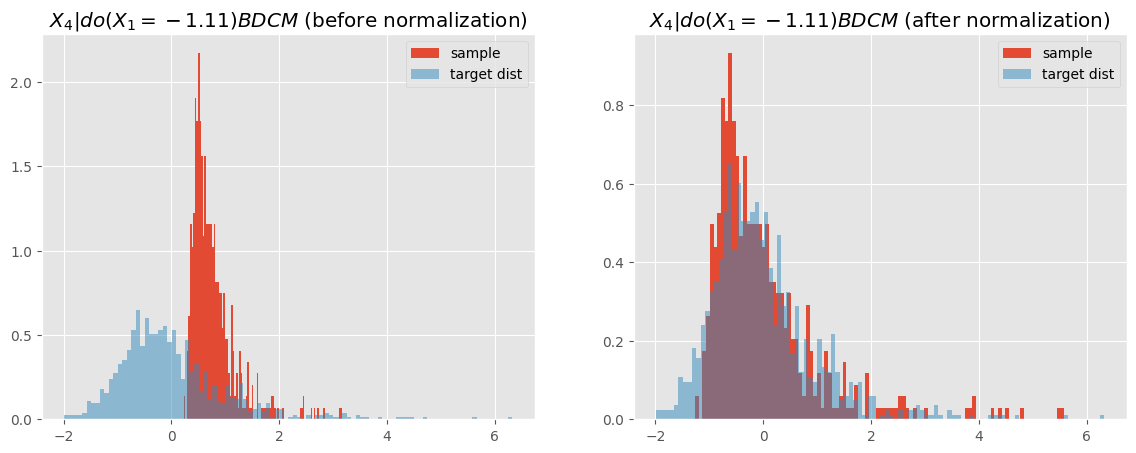

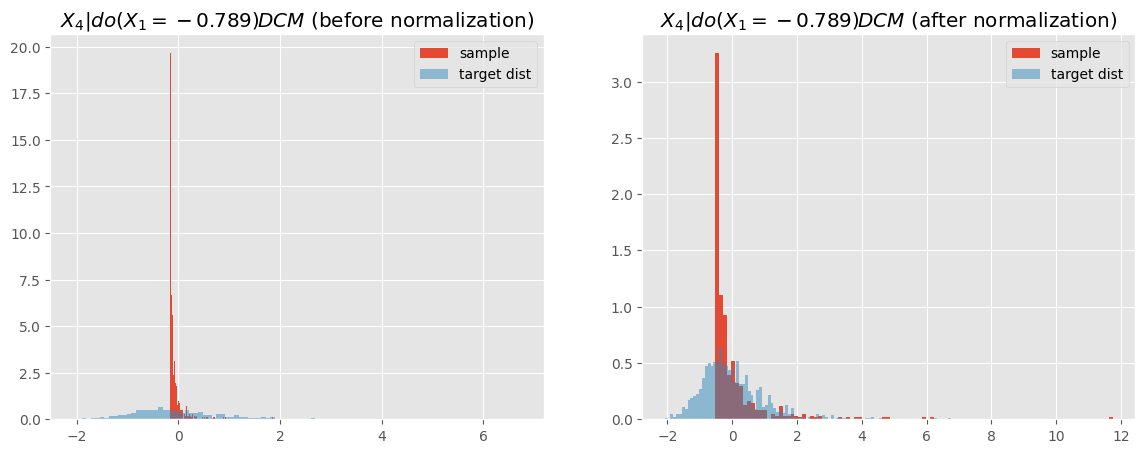

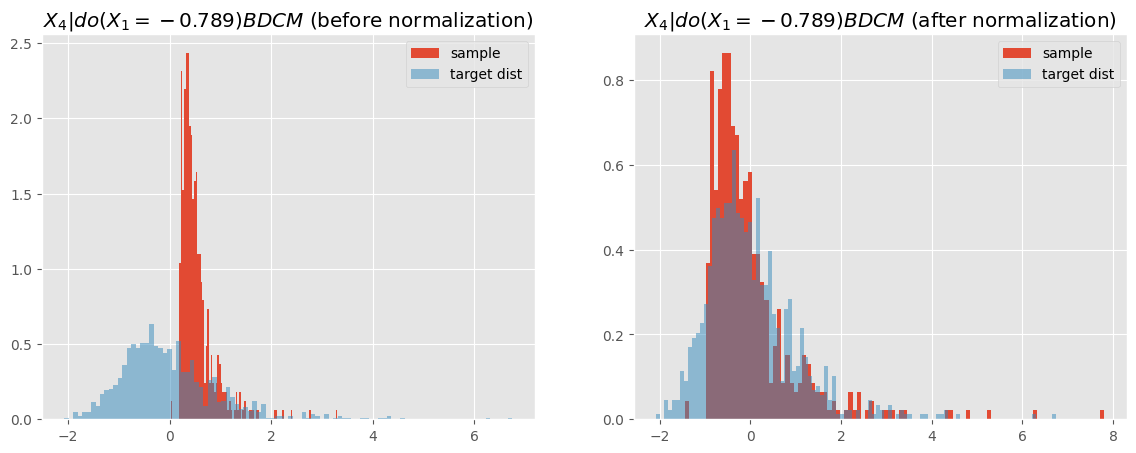

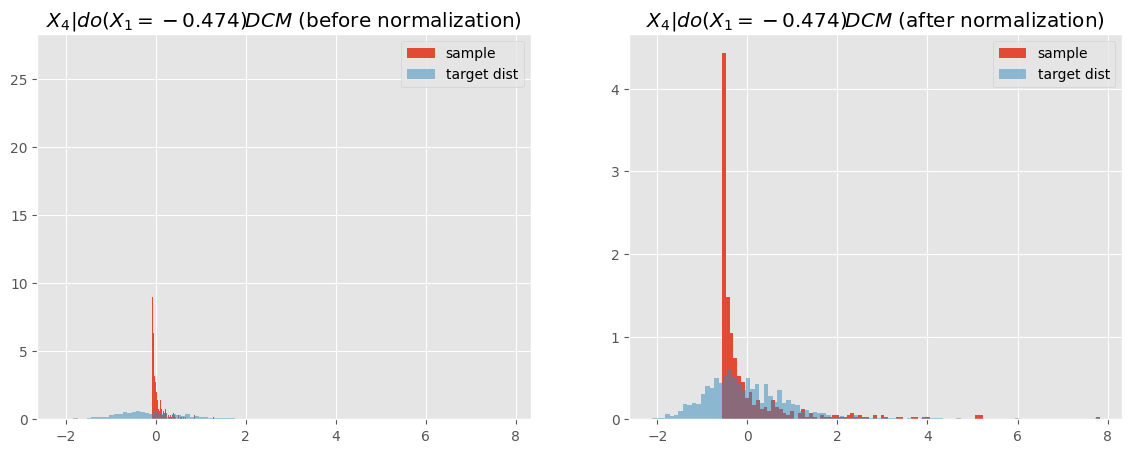

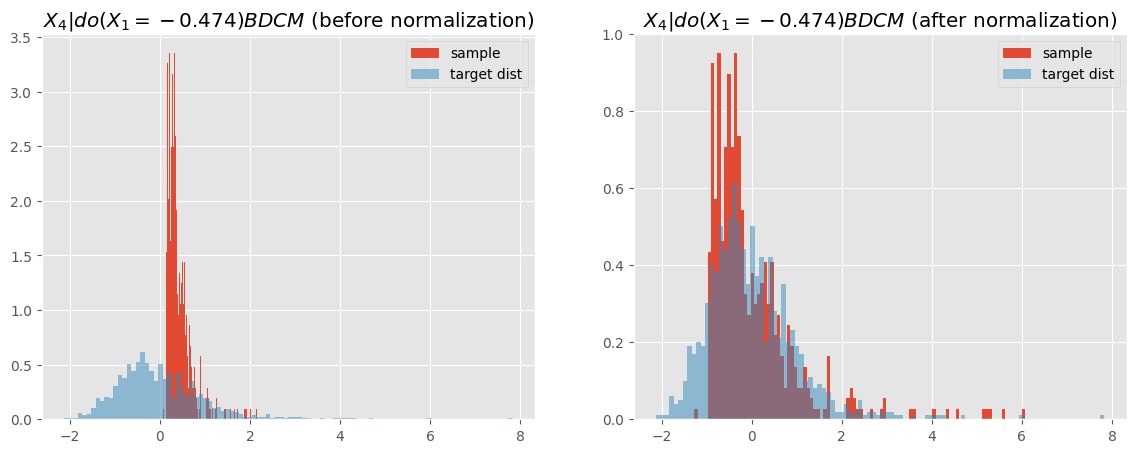

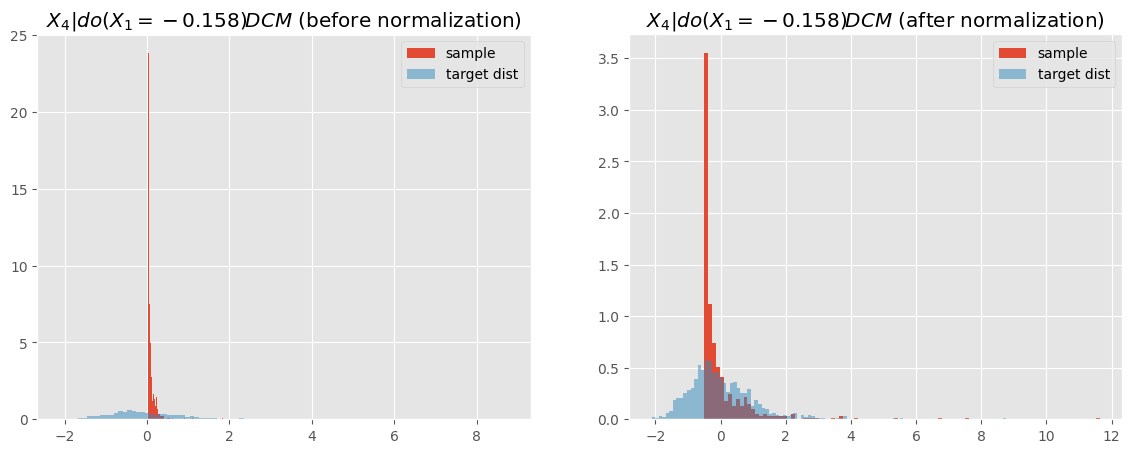

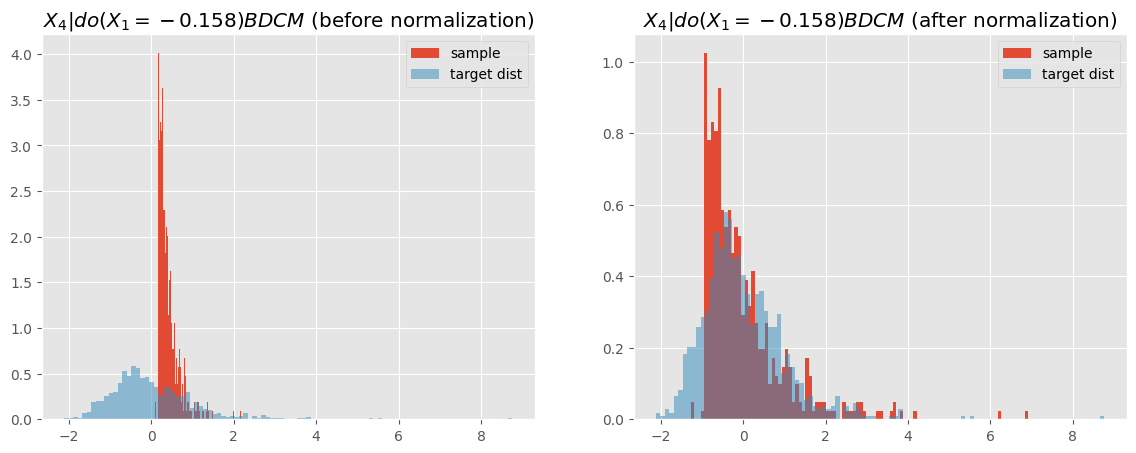

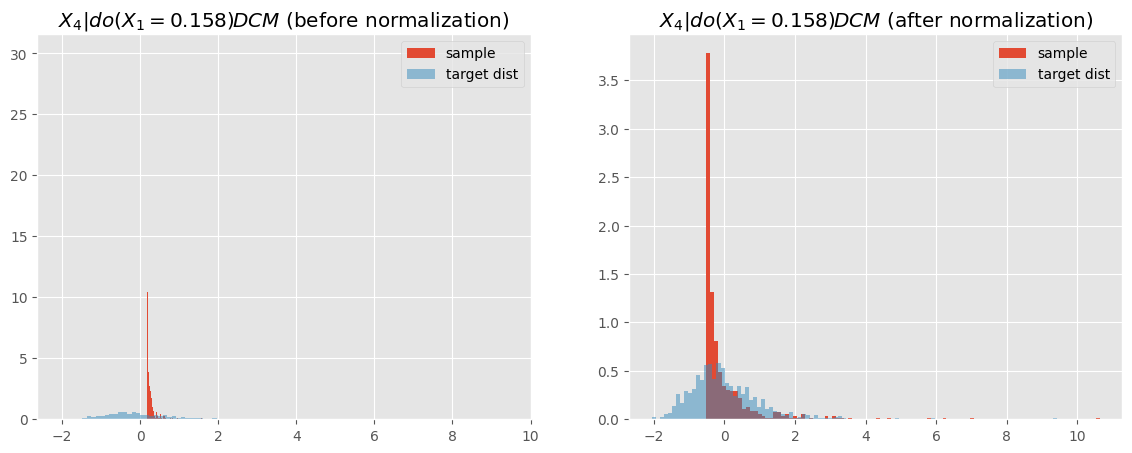

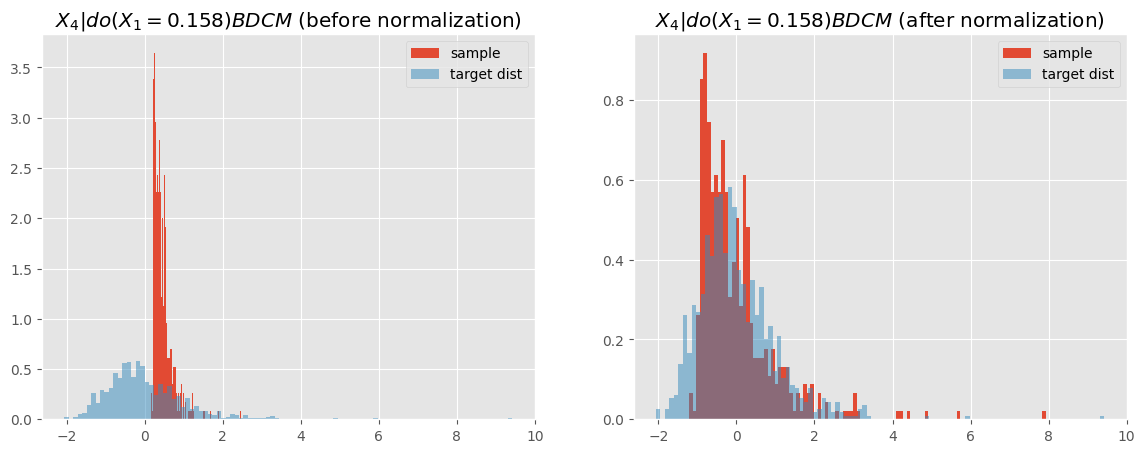

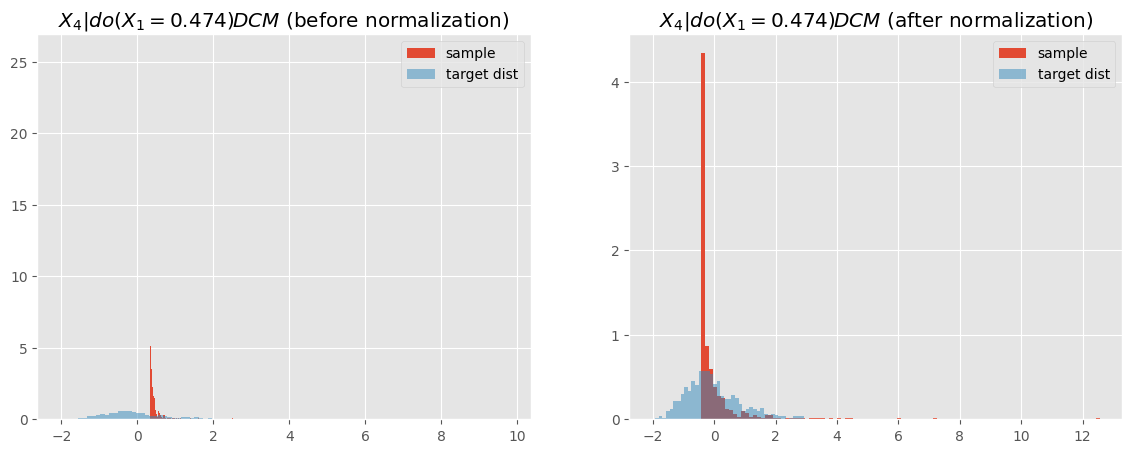

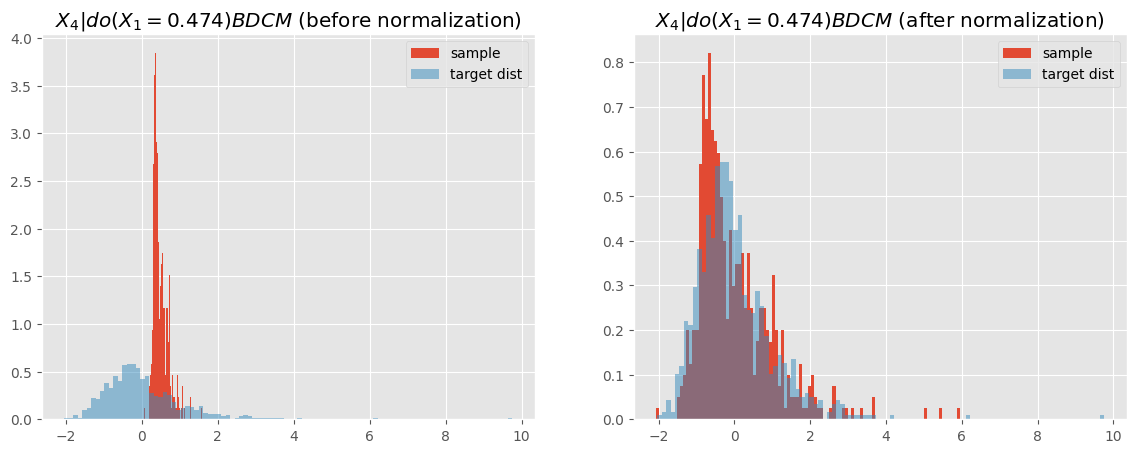

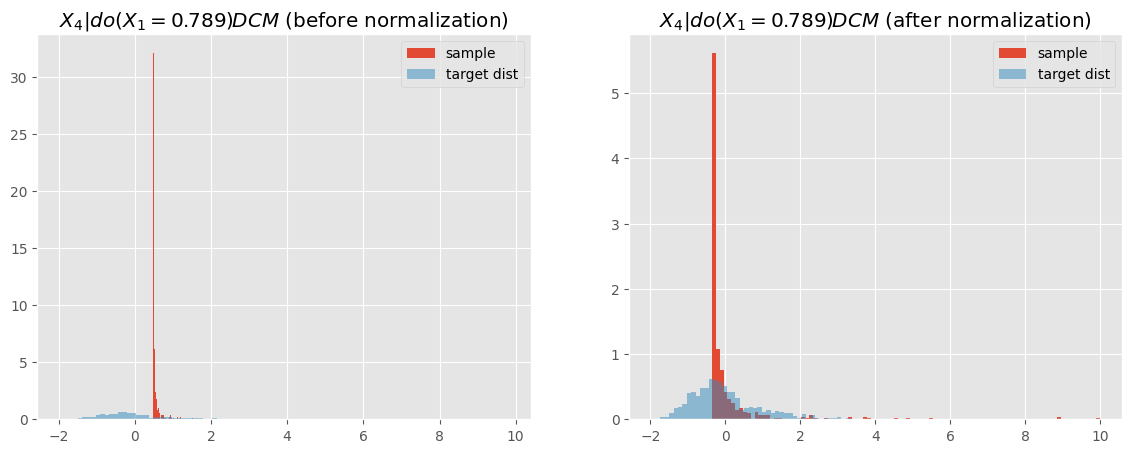

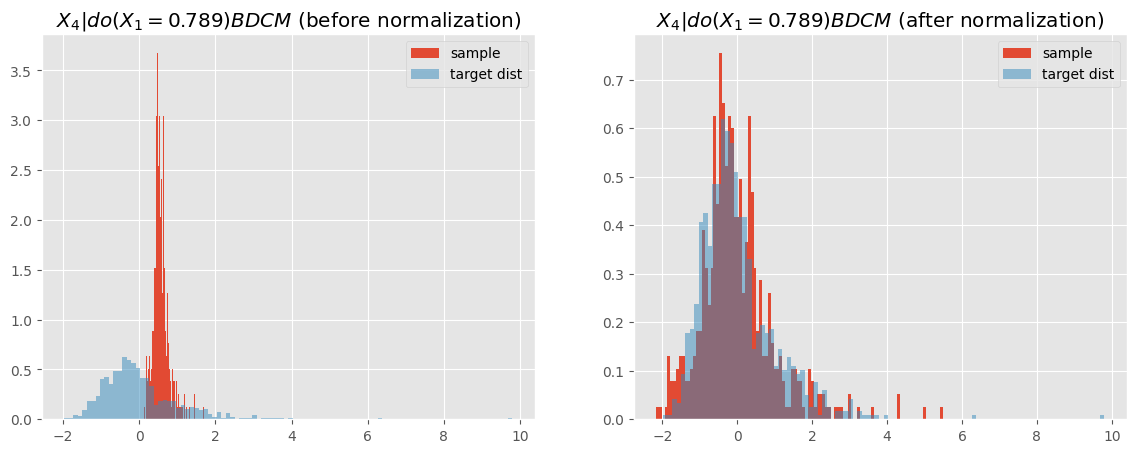

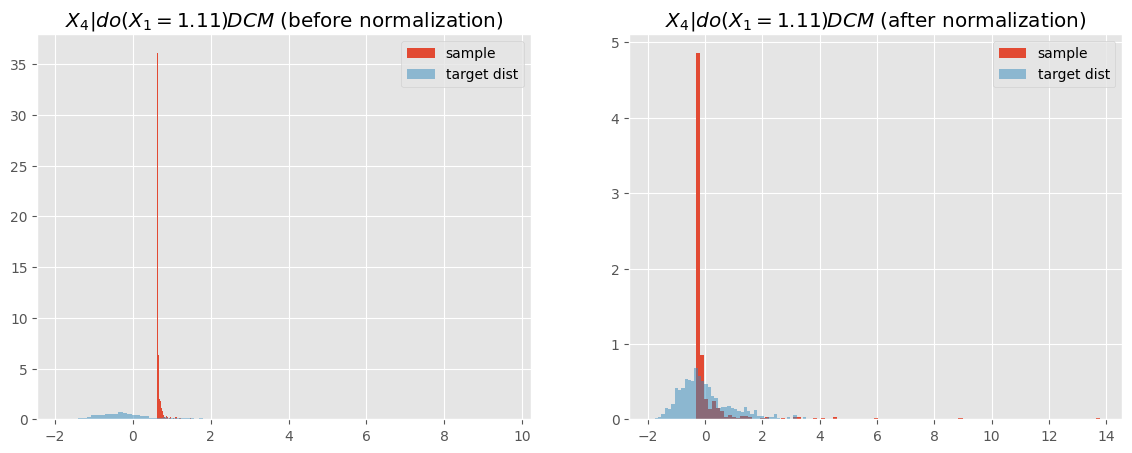

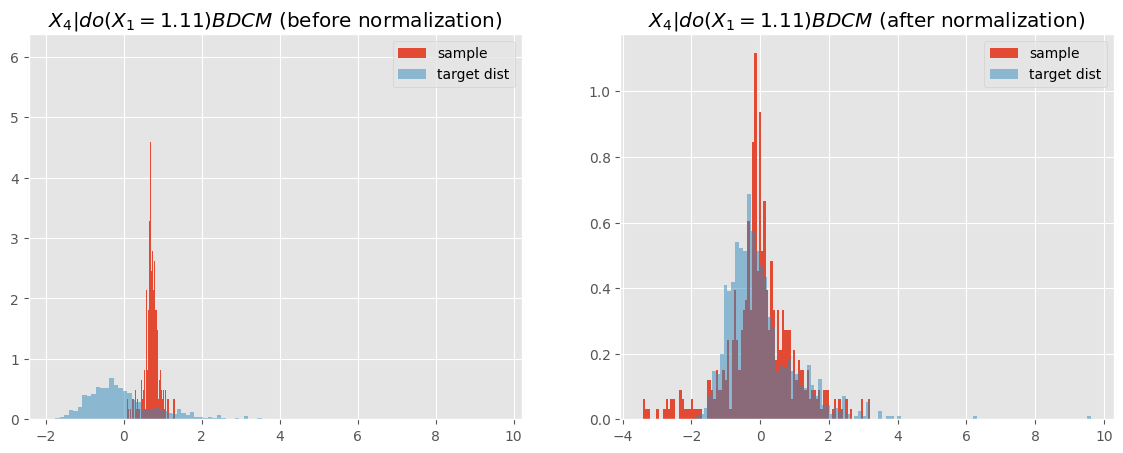

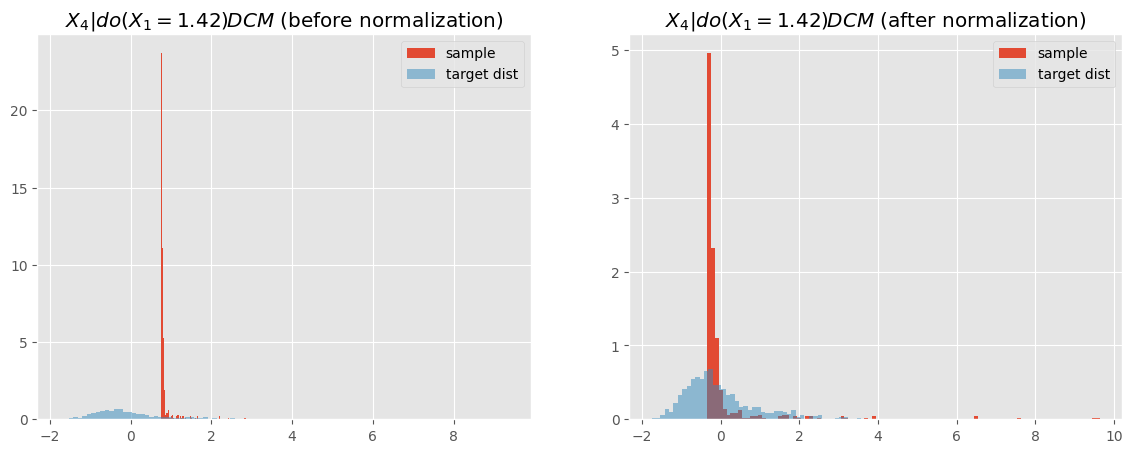

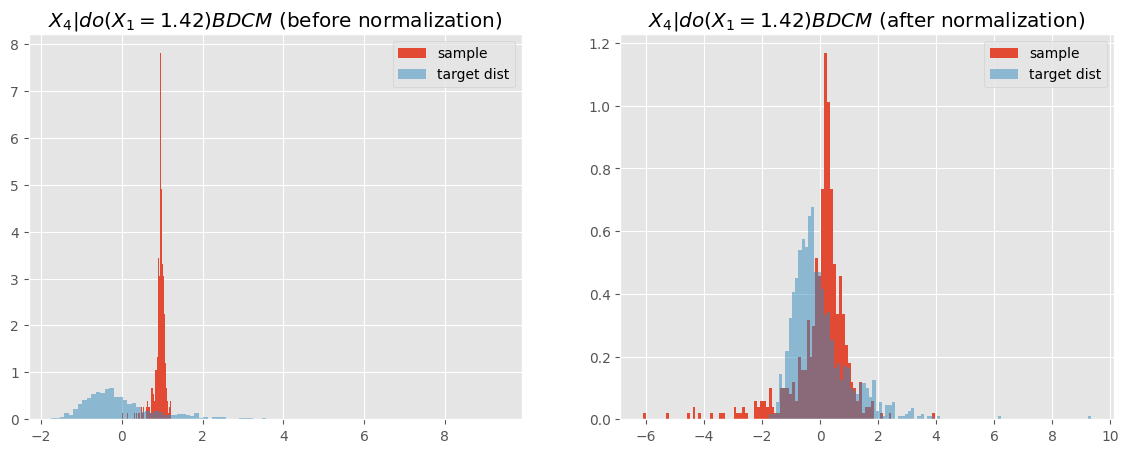

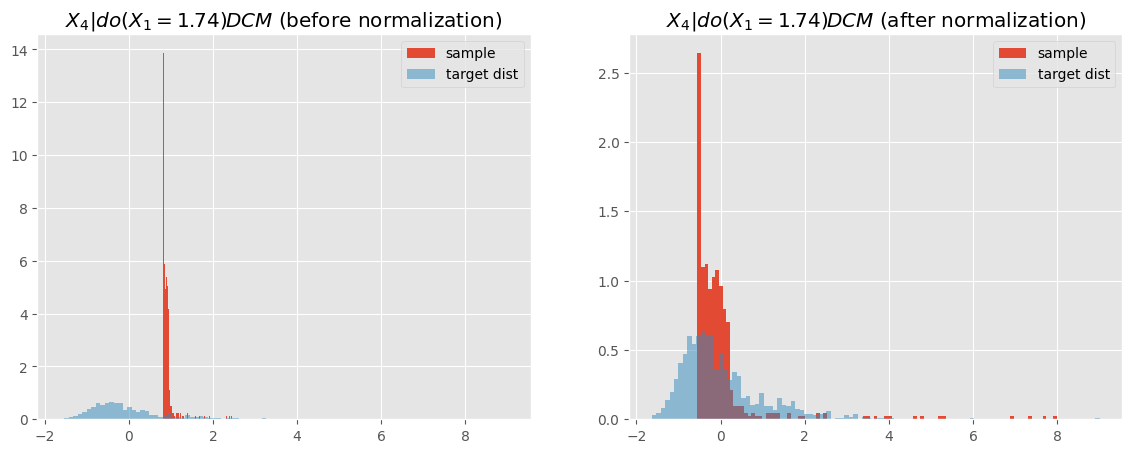

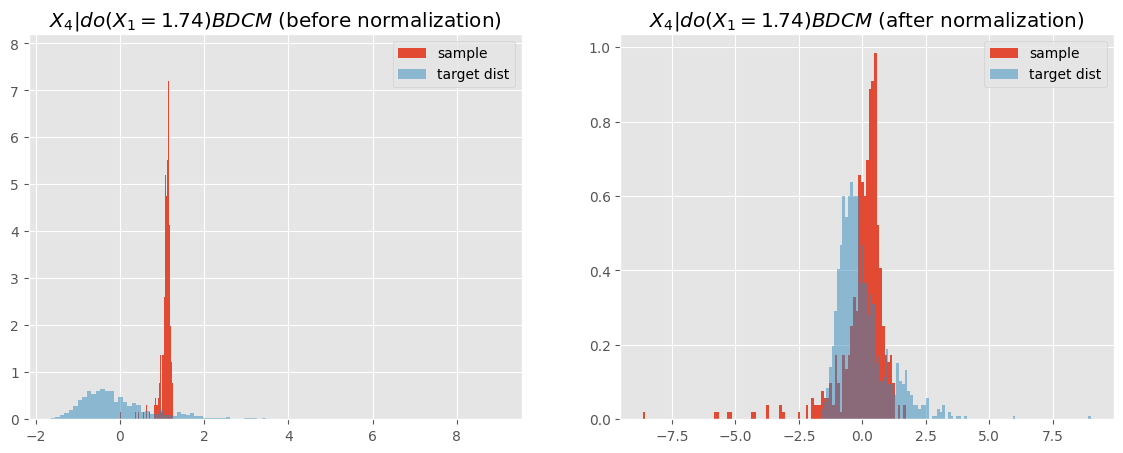

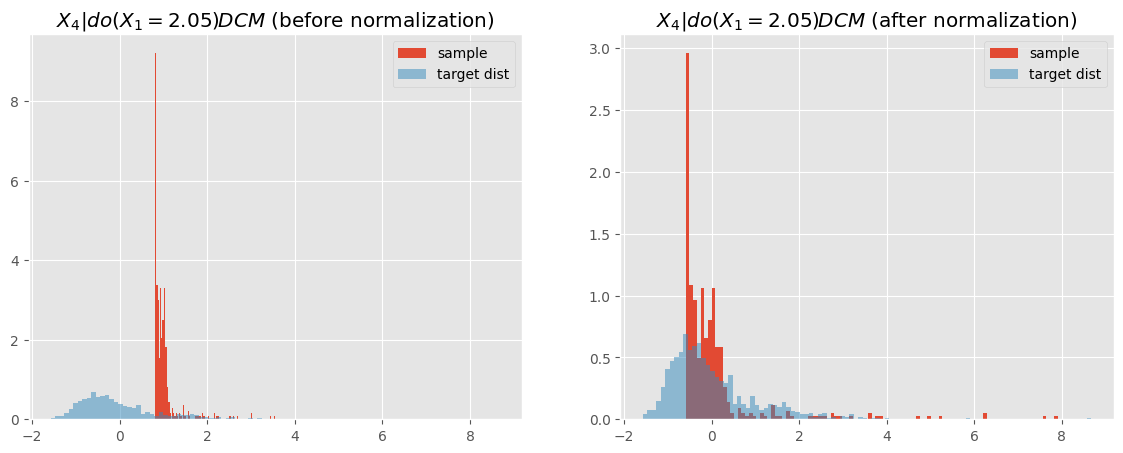

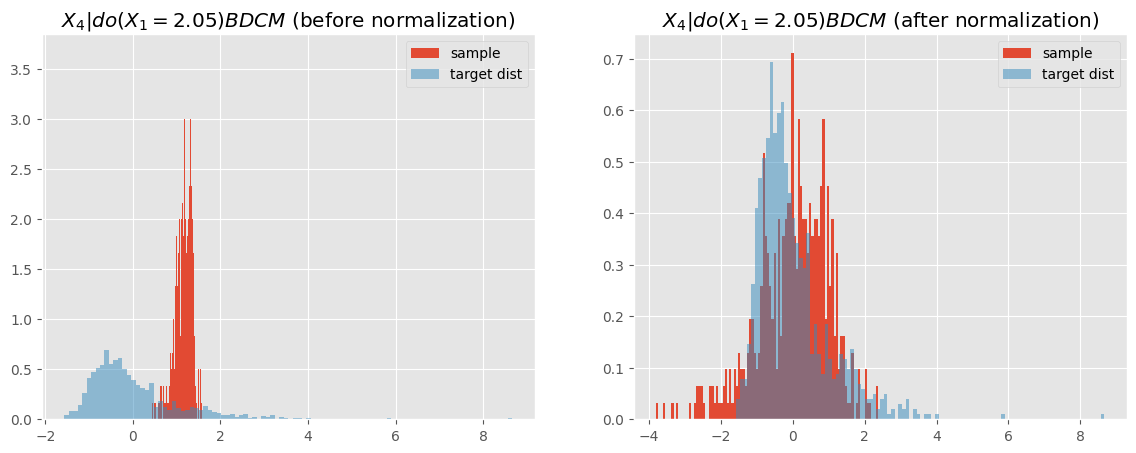

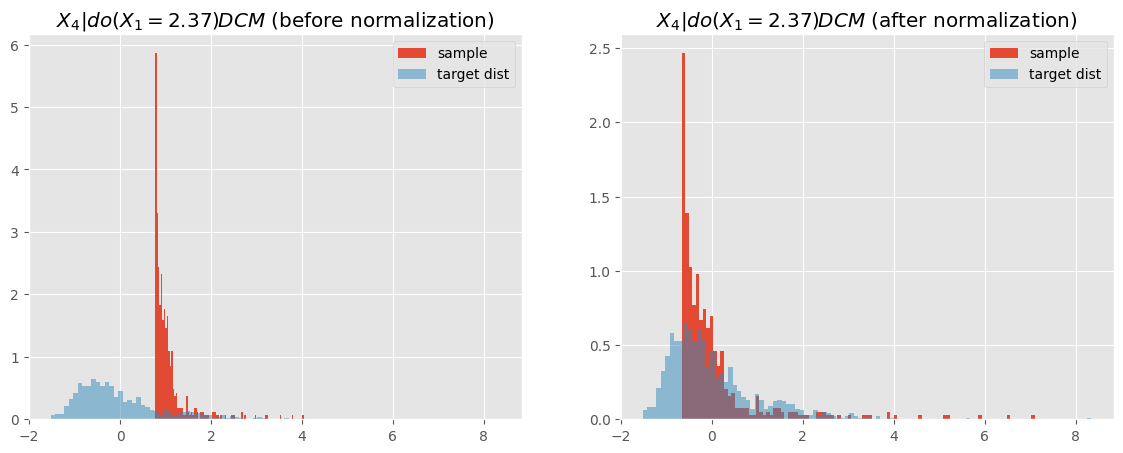

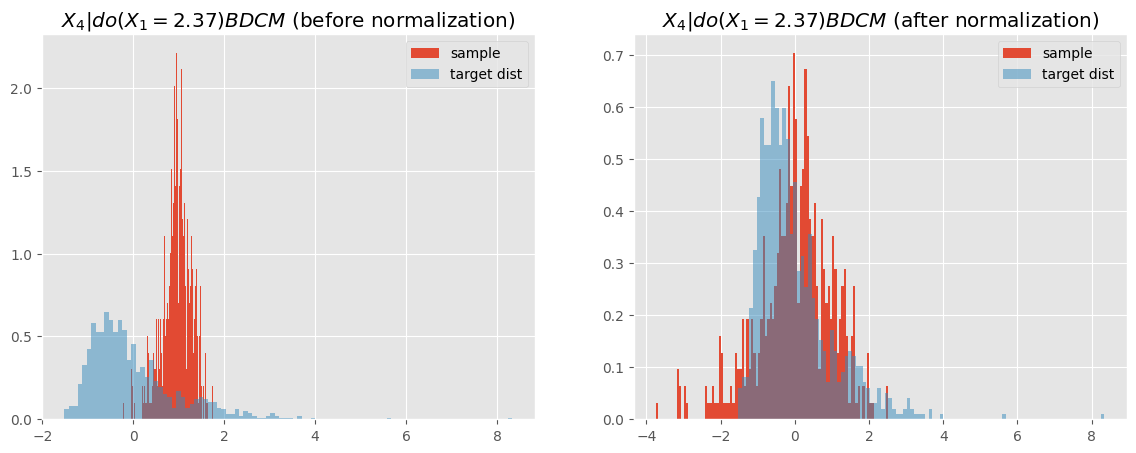

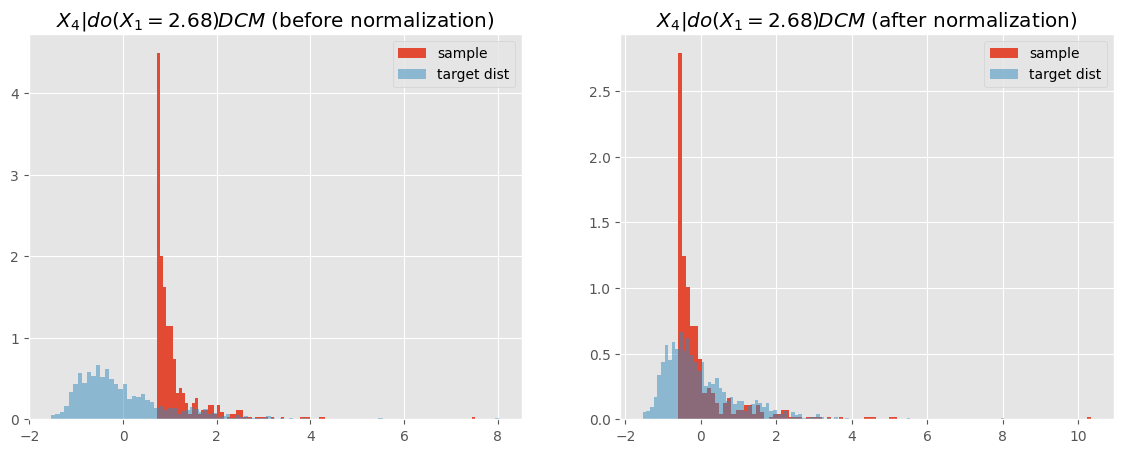

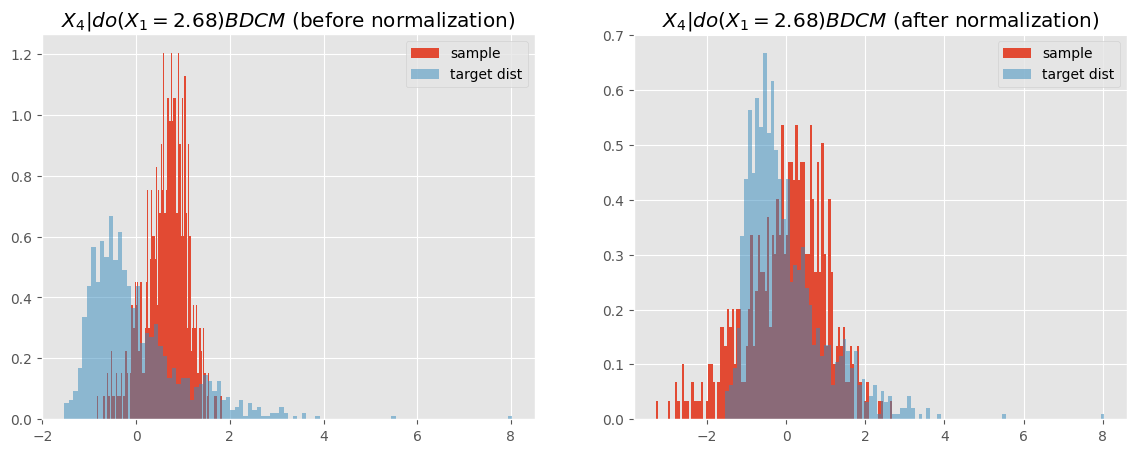

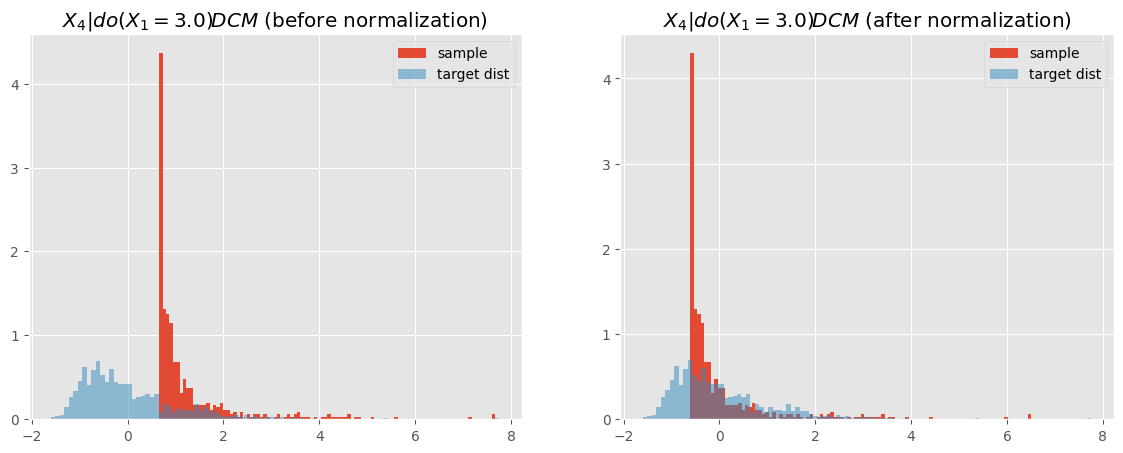

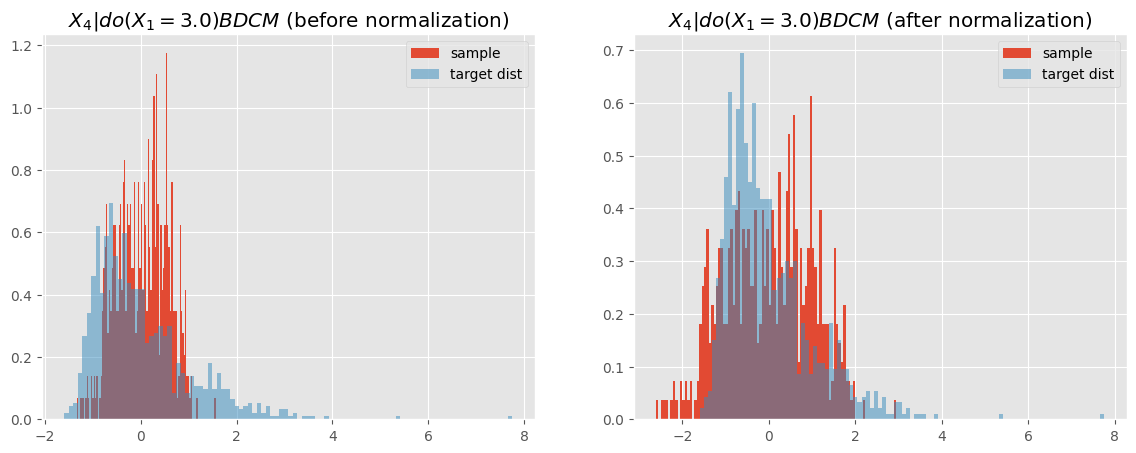

In [ ]:
# Define the array of interneved values
# 20 interventinos with the intervened value ranging from - to 2 linearly
array_interventions = np.linspace(-3, 3, 20)

# Get the samples from DCM and BDCM and
# Plot them compared with the target distribution
array_DCM_samples, array_BDCM_samples = plot_and_save_array(array_interventions)

<ipython-input-25-47ade29de131>:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  mmd_value = MMD(torch.tensor([normalize(array_DCM_samples[i])]).T.to(device), torch.tensor([normalize(true_sample_x4_do_x1(x1_internvened))[:n_sample_DCM]]).T.to(device), "rbf")


mean MMD for DCM: 0.00259
mean MMD for BDCM: 0.000715


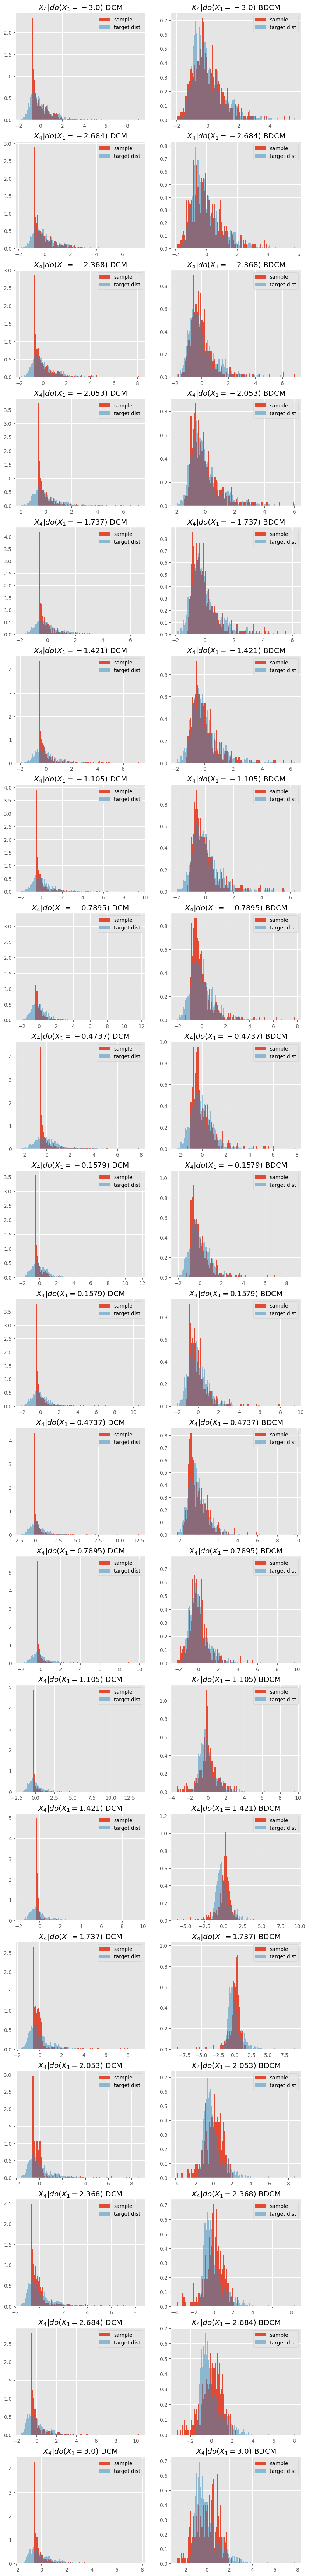

In [ ]:
import torch

# Calculate the number of intervention values
num_interventions = np.size(array_interventions)

# Show all the graphs and output MMD where we do(X_1 = x_1)
figure, axis = plt.subplots(num_interventions, 2, figsize=(10, 4.5 * num_interventions))

# Initialized the array that saves the values of MMD for DCM and BDCM
array_MMD_DCM = np.array([])
array_MMD_BDCM = np.array([])

# for loop for each intervened value
for i in range(num_interventions):
  # Get the intervened value
  x1_internvened = array_interventions[i]

  # do(X_1 = x_1) DCM
  # Plot samples from DCM
  axis[i][0].hist(normalize(array_DCM_samples[i]), 100, density = True, label = "sample")
  # Plot ground truth samples
  axis[i][0].hist(normalize(true_sample_x4_do_x1(x1_internvened)), 100, density = True, alpha = 0.5, label = "target dist")
  axis[i][0].set_title("$X_4|do(X_1 = {:.4})$ DCM".format(x1_internvened))
  axis[i][0].legend()
  # Calculate MMD
  mmd_value = MMD(torch.tensor([normalize(array_DCM_samples[i])]).T.to(device), torch.tensor([normalize(true_sample_x4_do_x1(x1_internvened))[:n_sample_DCM]]).T.to(device), "rbf")
  # print("MMD between sapmles from the true distribution and DCM: {:.3}".format(mmd_value.item()))
  # Add the new MMD into the array
  array_MMD_DCM = np.append(array_MMD_DCM, mmd_value.item())

  # do(X_1 = x_1) BDCM
  # Plot samples from BDCM
  axis[i][1].hist(normalize(array_BDCM_samples[i]), 100, density = True, label = "sample")
  # Plot ground truth sapmles
  axis[i][1].hist(normalize(true_sample_x4_do_x1(x1_internvened)), 100, density = True, alpha = 0.5, label = "target dist")
  axis[i][1].set_title("$X_4|do(X_1 = {:.4})$ BDCM".format(x1_internvened))
  axis[i][1].legend()
  # Calculate MMD
  mmd_value = MMD(torch.tensor([normalize(array_BDCM_samples[i])]).T.to(device), torch.tensor([normalize(true_sample_x4_do_x1(x1_internvened))[:n_sample_DCM]]).T.to(device), "rbf")
  # print("MMD between sapmles from the true distribution and BDCM: {:.3}".format(mmd_value.item()))
  # Add the new MMD into the array
  array_MMD_BDCM = np.append(array_MMD_BDCM, mmd_value.item())

# Output the mean MMD for DCM and BDCM
print("mean MMD for DCM: {:.3}".format(np.mean(array_MMD_DCM)))
print("mean MMD for BDCM: {:.3}".format(np.mean(array_MMD_BDCM)))

# Combine all the operations and display
plt.show()